In [45]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
import os
from dotenv import load_dotenv
load_dotenv(".env")

from langchain_openai import ChatOpenAI

In [46]:
# import the dataframe and print the first few lines to familiarize ourselves
df = pd.read_csv('salary_data_cleaned.csv')
print(df.shape)
df.head()

(742, 28)


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\n,FL,1,10,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\n,WA,1,55,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1


In [47]:
print("Columns: ", df.columns)
print("Dataframe shape: ", df.shape)

Columns:  Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel'],
      dtype='object')
Dataframe shape:  (742, 28)


In [48]:
# if executed, this function will lowercase all text cells
def lowercase_dataframe(df):
  for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str
  return d

#df = lowercase_dataframe(df)

In [49]:
# this is a manual clean-up code for organizing jobs into a few categories based on roles
# we will replace it with AI later

def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'

def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower():
        return 'jr'
    else:
        return 'na'


In [50]:
df['job_simp'] = df['Job Title'].apply(title_simplifier)
df[['job_simp','Job Title']].head()

,job_simp,Job Title
0,data scientist,Data Scientist
1,data scientist,Healthcare Data Scientist
2,data scientist,Data Scientist
3,data scientist,Data Scientist
4,data scientist,Data Scientist


job_simp
data scientist    279
na                184
data engineer     119
analyst           102
manager            22
mle                22
director           14
Name: count, dtype: int64


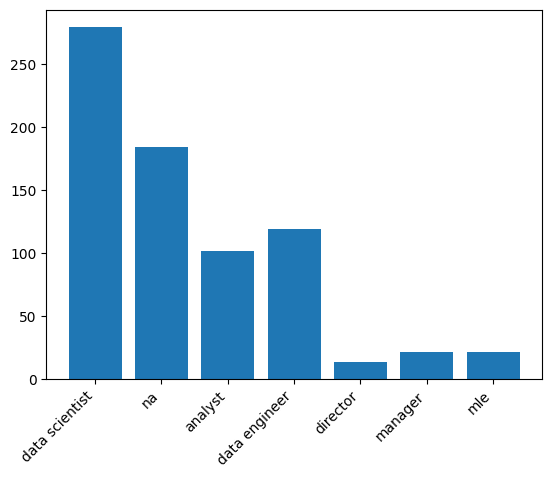

In [51]:
print(df.job_simp.value_counts())
counts = [df['job_simp'].value_counts()[each] for each in df['job_simp']]
#print(counts)
plt.bar(df['job_simp'],counts)
plt.xticks(rotation=45, ha='right')
plt.show()
#df.plot.bar(x='job_simp',y=counts)


In [52]:
# now we will create a seniority column with our predefined seniority function
df['seniority'] = df['Job Title'].apply(seniority)
df.seniority.value_counts()

seniority
na        520
senior    220
jr          2
Name: count, dtype: int64

In [53]:
df['job_state'].unique()
for each in df['job_state'].unique():
    if len(each.strip())!=2:
        print(str(each))

 Los Angeles


In [54]:
# Fix state Los Angeles 
df['job_state']= df.job_state.apply(lambda x: x.strip() if x.strip().lower() != 'los angeles' else 'CA')
print(df['job_state'].unique())
df.job_state.value_counts()


['NM' 'MD' 'FL' 'WA' 'NY' 'TX' 'CA' 'VA' 'MA' 'NJ' 'CO' 'IL' 'KY' 'OR'
 'CT' 'MI' 'DC' 'OH' 'AL' 'MO' 'PA' 'GA' 'IN' 'LA' 'WI' 'NC' 'AZ' 'NE'
 'MN' 'UT' 'TN' 'DE' 'ID' 'RI' 'IA' 'SC' 'KS']


job_state
CA    152
MA    103
NY     72
VA     41
IL     40
MD     35
PA     33
TX     28
NC     21
WA     21
NJ     17
FL     16
OH     14
TN     13
DC     11
CO     11
WI     10
UT     10
IN     10
AZ      9
MO      9
AL      8
GA      6
DE      6
KY      6
MI      6
CT      5
IA      5
LA      4
OR      4
NE      4
NM      3
KS      3
ID      2
MN      2
RI      1
SC      1
Name: count, dtype: int64

In [55]:
#  Job description length in characters
df['desc_len'] = df['Job Description'].apply(lambda x: len(x))
df['desc_len']

0       2536
1       4783
2       3461
3       3883
4       2728
5       3747
6       1786
7       3804
8       1538
9       4574
10      2757
11      3490
12      3934
13      4897
14      3731
15      1889
16      3639
17      4163
18      3512
19      4397
20      2918
21      6909
22      6408
23      2907
24      3760
25      3698
26      4420
27      4900
28      5015
29      3461
30      3883
31      3342
32      5045
33      2327
34      2161
35      1739
36      5000
37      3703
38      3555
39      1739
40      3053
41      1996
42      3833
43      3550
44      9120
45      3213
46      7286
47      3412
48      2682
49      2739
50      2915
51      4244
52      1629
53      4734
54      4448
55      3543
56      4203
57      5020
58      1786
59      3747
60      4804
61      1382
62      2933
63      4945
64      2493
65      1939
66      3081
67      8397
68      2306
69      2291
70      1886
71      2903
72      2653
73      4427
74      2609
75      4295
76      3405

In [56]:
#Competitor count
df['num_comp'] = df['Competitors'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)

In [57]:
df['Competitors'].head()

0                                                   -1
1                                                   -1
2                                                   -1
3    Oak Ridge National Laboratory, National Renewa...
4                 Commerce Signals, Cardlytics, Yodlee
Name: Competitors, dtype: object

In [58]:
hourly_df = df[df['hourly']==1]
print(hourly_df[['Salary Estimate','min_salary','max_salary','hourly']].head())

                      Salary Estimate  min_salary  max_salary  hourly
165  $17-$24 Per Hour(Glassdoor est.)          17          24       1
177  $21-$34 Per Hour(Glassdoor est.)          21          34       1
197  $18-$25 Per Hour(Glassdoor est.)          18          25       1
202  $21-$34 Per Hour(Glassdoor est.)          21          34       1
210  $15-$25 Per Hour(Glassdoor est.)          15          25       1


In [59]:
#hourly wage to annual 
df['min_salary'] = df.apply(lambda x: x.min_salary*12 if x.hourly ==1 else x.min_salary, axis =1)
df['max_salary'] = df.apply(lambda x: x.max_salary*12 if x.hourly ==1 else x.max_salary, axis =1)

In [60]:
df[df.hourly ==1][['hourly','min_salary','max_salary']]

,hourly,min_salary,max_salary
165,1,204,288
177,1,252,408
197,1,216,300
202,1,252,408
210,1,180,300
246,1,204,288
271,1,252,408
337,1,216,300
345,1,288,468
357,1,252,408


In [61]:
df['company_txt'] = df.company_txt.apply(lambda x: x.strip())

In [62]:
df['company_txt']

0                                      Tecolote Research
1                  University of Maryland Medical System
2                                                KnowBe4
3                                                   PNNL
4                                     Affinity Solutions
5                                               CyrusOne
6                                     ClearOne Advantage
7                                             Logic20/20
8                              Rochester Regional Health
9                                               <intent>
10                                                  Wish
11                                               ManTech
12                                               Walmart
13                                                Yesler
14                                Takeda Pharmaceuticals
15                                               Audible
16                                   Blueprint Medicines
17                             

In [63]:
df.describe()

,Rating,Founded,hourly,employer_provided,min_salary,max_salary,avg_salary,same_state,age,python_yn,R_yn,spark,aws,excel,desc_len,num_comp
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1837.154987,0.032345,0.022911,81.229111,137.812668,100.626011,0.557951,46.591644,0.528302,0.002695,0.225067,0.237197,0.522911,3869.545822,1.053908
std,0.801210,497.183763,0.177034,0.149721,43.158639,61.161552,38.855948,0.496965,53.778815,0.499535,0.051882,0.417908,0.425651,0.499812,1521.495868,1.384239
min,-1.000000,-1.000000,0.000000,0.000000,15.000000,16.000000,13.500000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000
25%,3.300000,1939.000000,0.000000,0.000000,54.000000,99.000000,73.500000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2801.000000,0.000000
50%,3.700000,1988.000000,0.000000,0.000000,72.000000,127.000000,97.500000,1.000000,24.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3731.000000,0.000000
75%,4.000000,2007.000000,0.000000,0.000000,97.000000,160.000000,122.500000,1.000000,59.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4740.000000,3.000000
max,5.000000,2019.000000,1.000000,1.000000,324.000000,564.000000,254.000000,1.000000,276.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10051.000000,4.000000


In [64]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

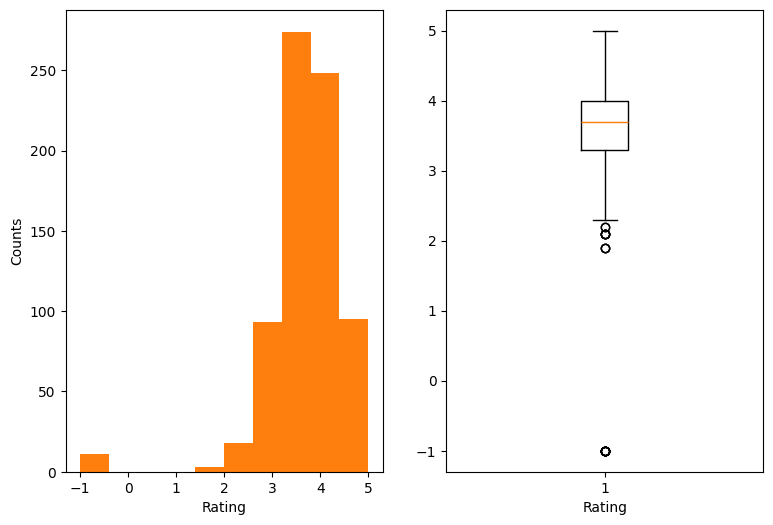

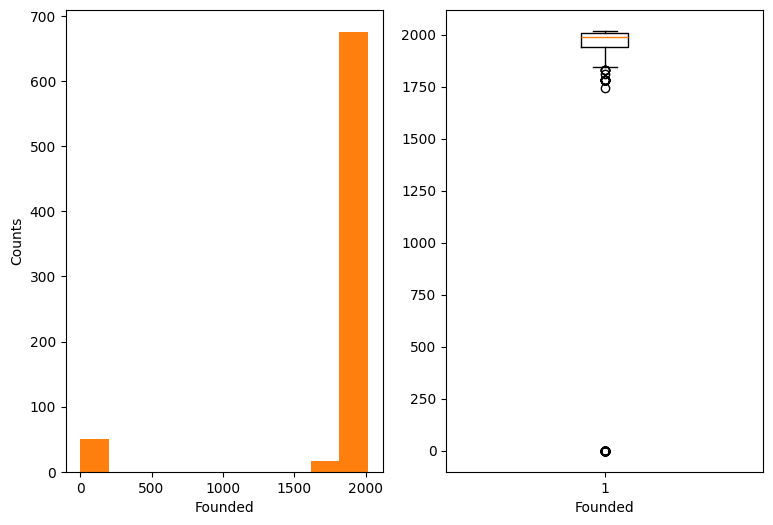

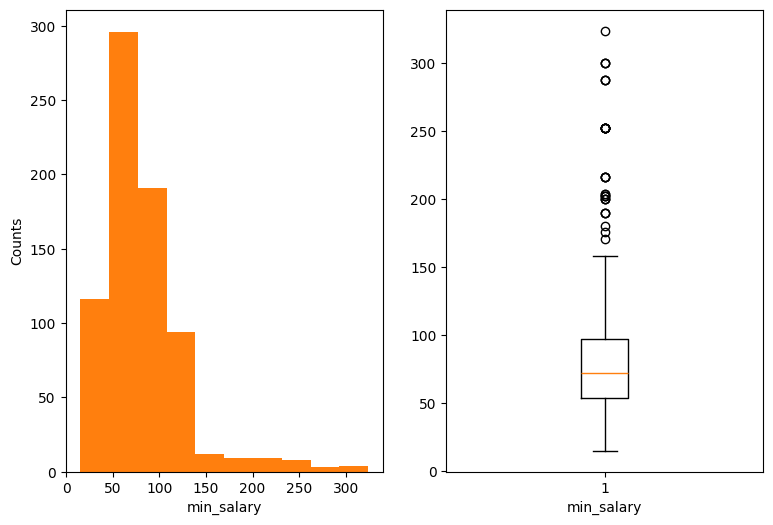

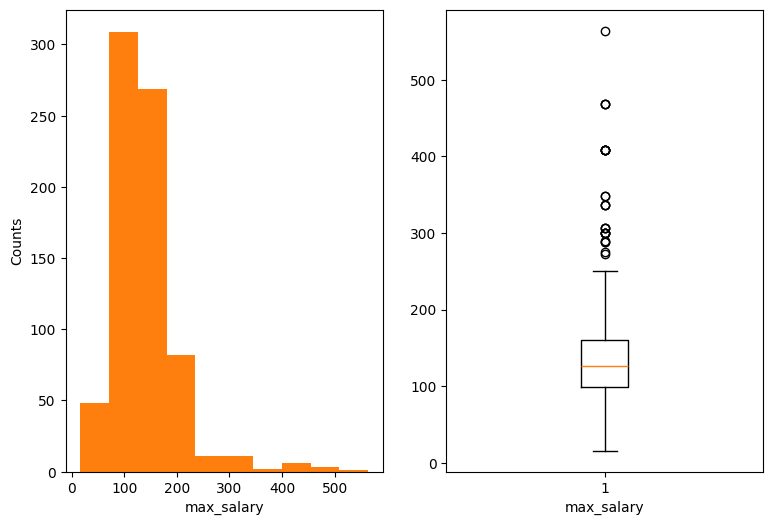

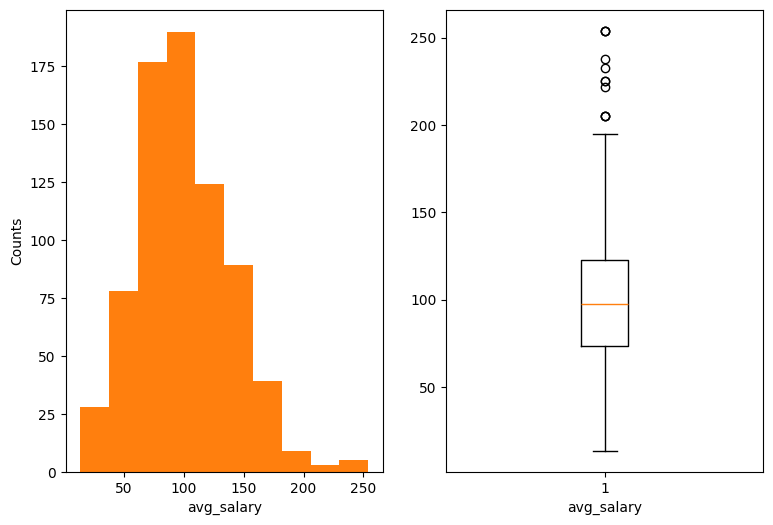

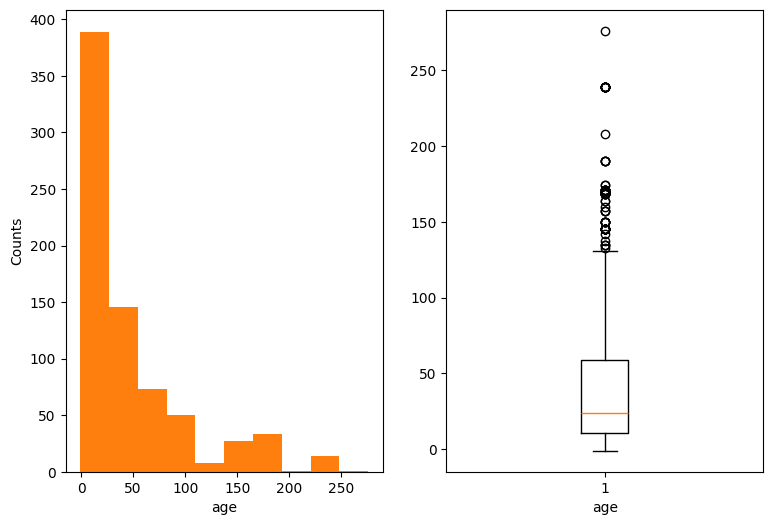

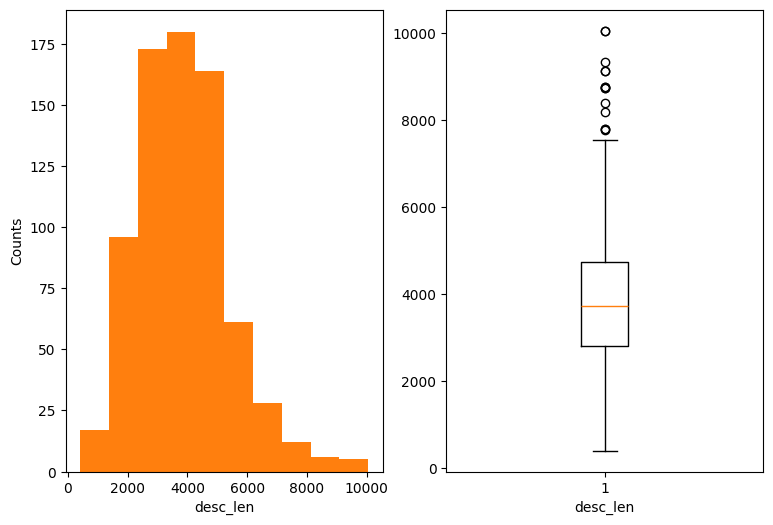

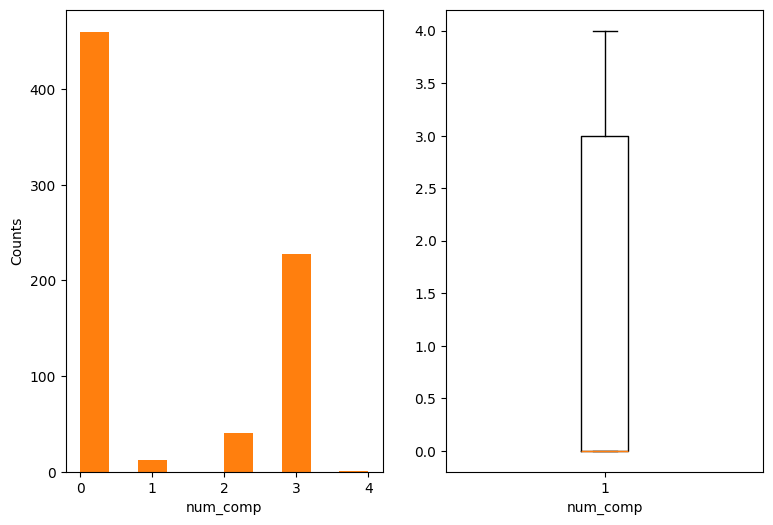

In [65]:
# make a histogram for each numeric column
numeric_df = df.select_dtypes(include=np.number)
for each in numeric_df.columns:
    if numeric_df[each].nunique()>2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        ax1.hist(numeric_df[each])
        ax2.boxplot(numeric_df[each])
        ax1.hist(numeric_df[each])
        ax1.set(xlabel=each, ylabel='Counts')
        ax2.set(xlabel=each)

In [66]:
# We saw from the histograms above that -1 makes its way into Rating and Founded columns
# when data is missing. We'll remove lines that have -1 for any features

def remove_negative_one_rows(df):
    """
    Removes rows from df that have -1 in any column
    Args: df (pd.DataFrame) The input DataFrame.
    Returns: pd.Dataframe: a new DataFrame with specified rows removed. 
    """
    return df[~(df==-1).any(axis=1)]

df = remove_negative_one_rows(df)

In [67]:
df[['age','avg_salary','Rating','desc_len']].corr()

,age,avg_salary,Rating,desc_len
age,1.000000,0.032270,-0.108796,0.148882
avg_salary,0.032270,1.000000,0.129638,0.107366
Rating,-0.108796,0.129638,1.000000,-0.102428
desc_len,0.148882,0.107366,-0.102428,1.000000


<Axes: >

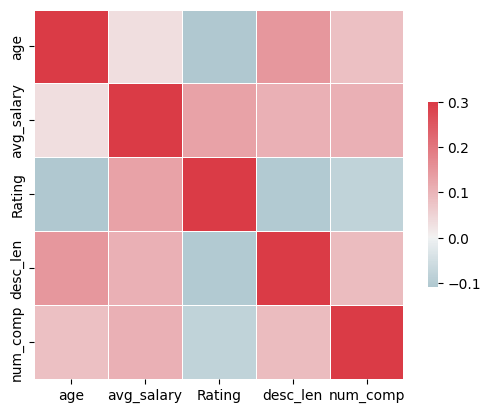

In [68]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df[['age','avg_salary','Rating','desc_len','num_comp']].corr(),vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: >

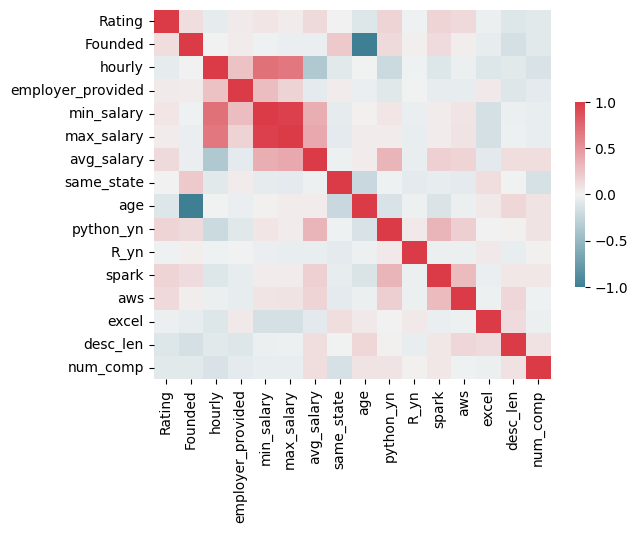

In [69]:
# bigger heat map
numeric_df = df.select_dtypes(include=np.number)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(numeric_df.corr(),cmap=cmap,cbar_kws={"shrink": .5})

In [70]:
def get_highest_correlation_pairs(df, n=5):
    """
    Returns the top N highest correlation pairs in a DataFrame, excluding self-correlations.

    Args:
        df (pd.DataFrame): The input DataFrame.
        n (int, optional): The number of top correlation pairs to return. Defaults to 5.

    Returns:
        pd.Series: A Series containing the top N highest correlation pairs and their coefficients.
    """
    corr_matrix = df.corr()
    corr_matrix = corr_matrix.mask(np.equal(*np.indices(corr_matrix.shape)))
    corr_series = corr_matrix.unstack()
    top_corr_series = corr_series.sort_values(ascending=False).head(n)
    return top_corr_series

get_highest_correlation_pairs(numeric_df, n=10)

min_salary  max_salary    0.963903
max_salary  min_salary    0.963903
min_salary  hourly        0.697870
hourly      min_salary    0.697870
max_salary  hourly        0.669797
hourly      max_salary    0.669797
max_salary  avg_salary    0.405470
avg_salary  max_salary    0.405470
min_salary  avg_salary    0.372245
avg_salary  min_salary    0.372245
dtype: float64

In [71]:
# filter out category columns
df_cat = df[['Location', 'Headquarters', 'Size','Type of ownership', 'Industry', 'Sector', 'Revenue', 'company_txt', 'job_state','same_state', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority']]

graph for Location: total = 186
186


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


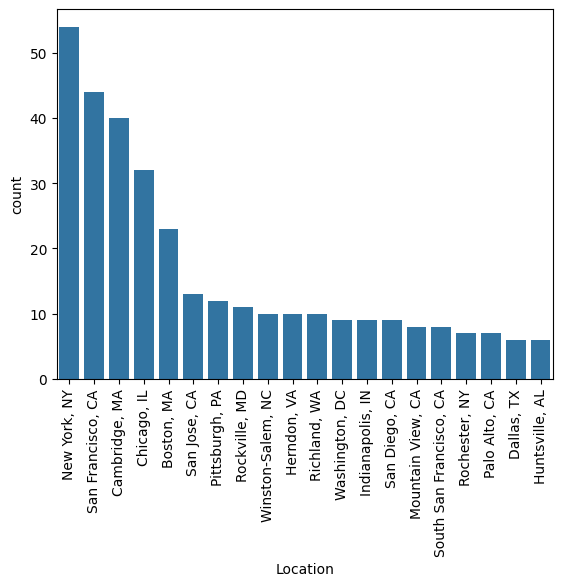

graph for Headquarters: total = 180
180


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


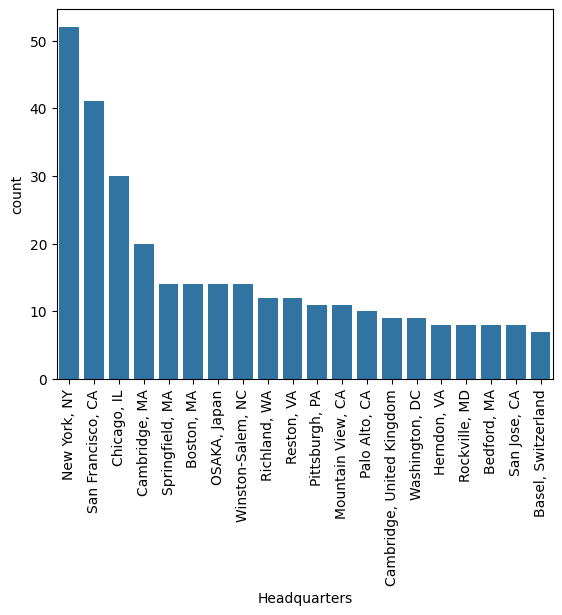

graph for Size: total = 7
7


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


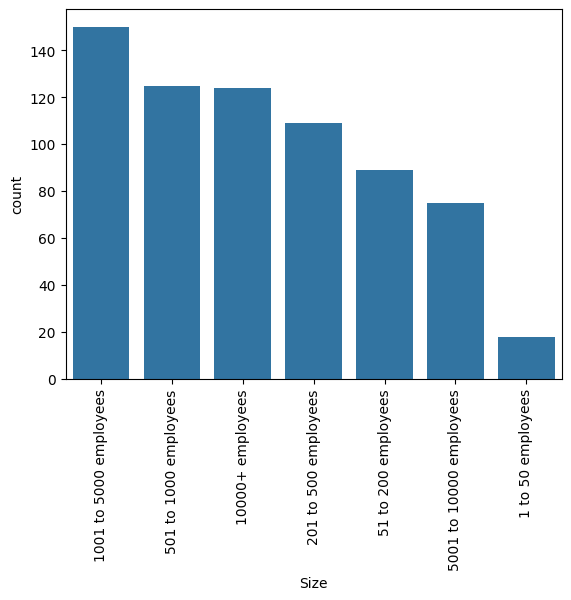

graph for Type of ownership: total = 10
10


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


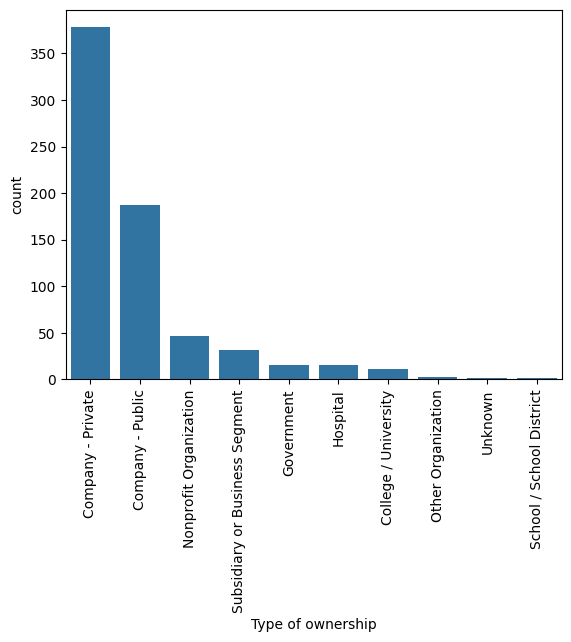

graph for Industry: total = 56
56


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


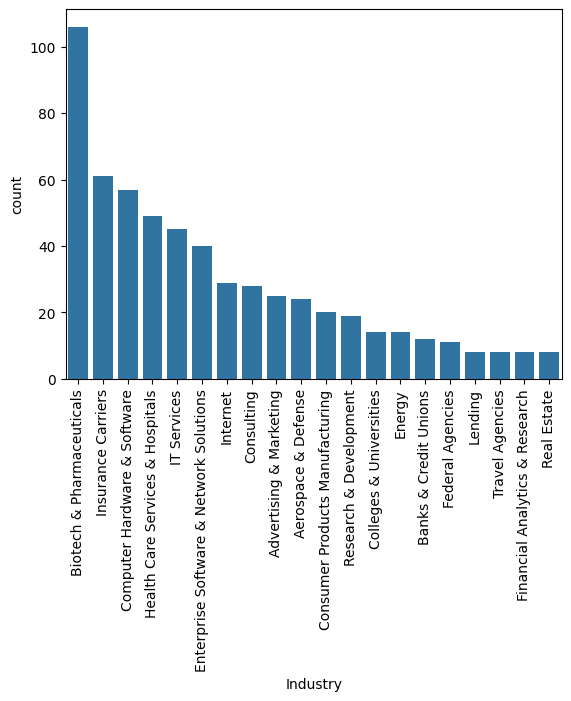

graph for Sector: total = 23
23


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


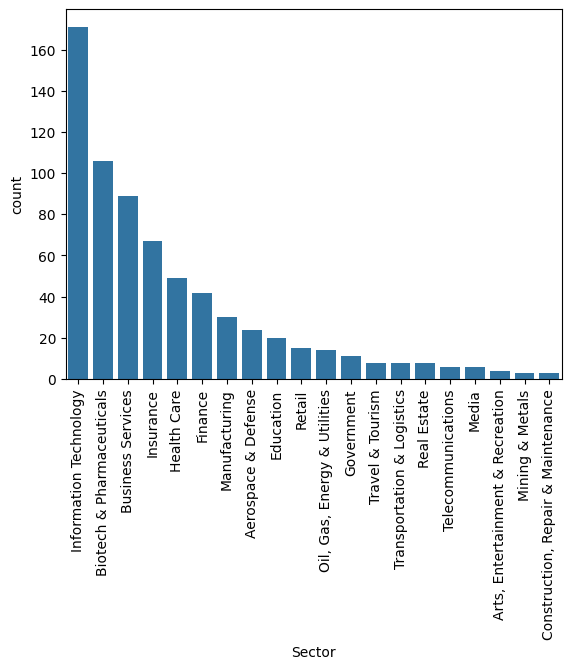

graph for Revenue: total = 12
12


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


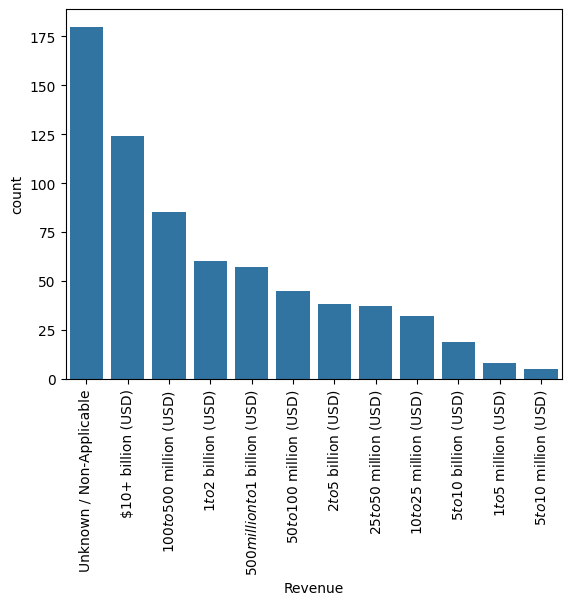

graph for company_txt: total = 318
318


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


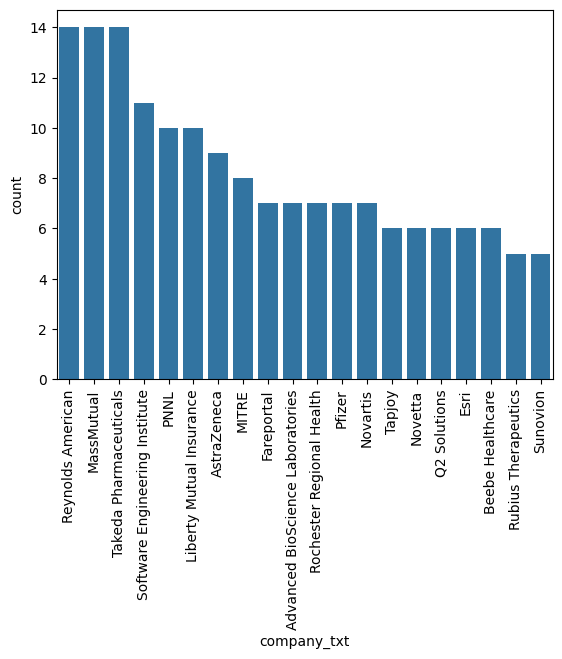

graph for job_state: total = 37
37


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


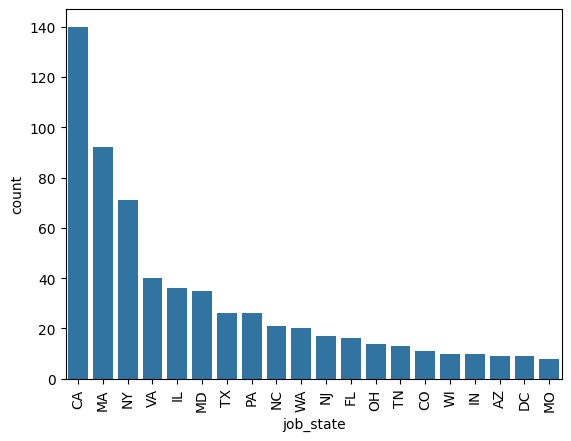

graph for same_state: total = 2
2


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


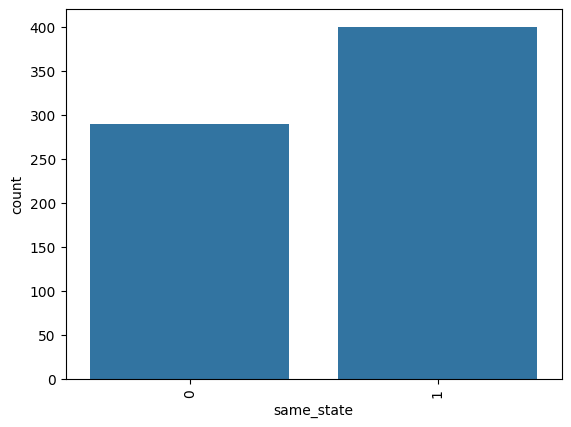

graph for python_yn: total = 2
2


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


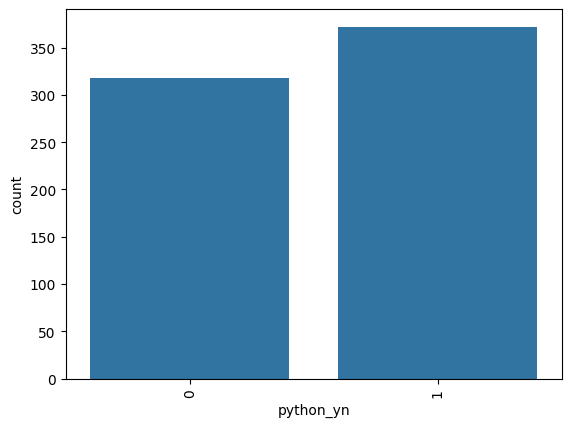

graph for R_yn: total = 2
2


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


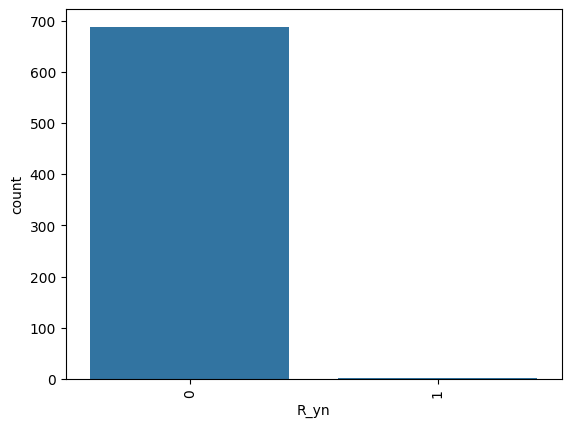

graph for spark: total = 2
2


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


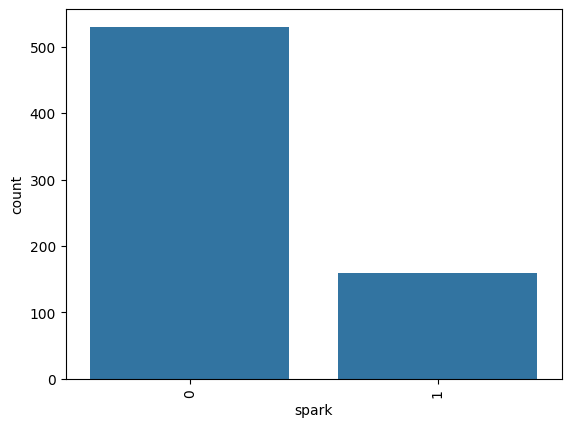

graph for aws: total = 2
2


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


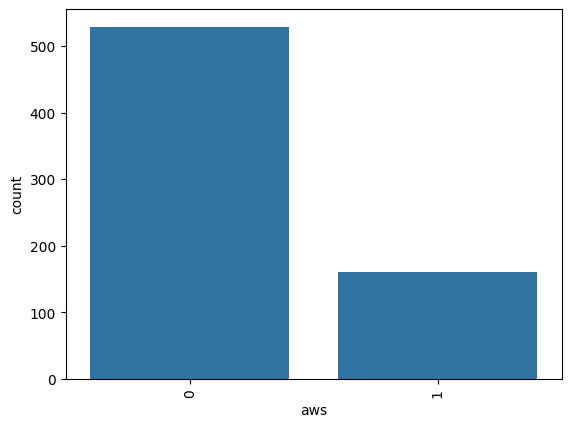

graph for excel: total = 2
2


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


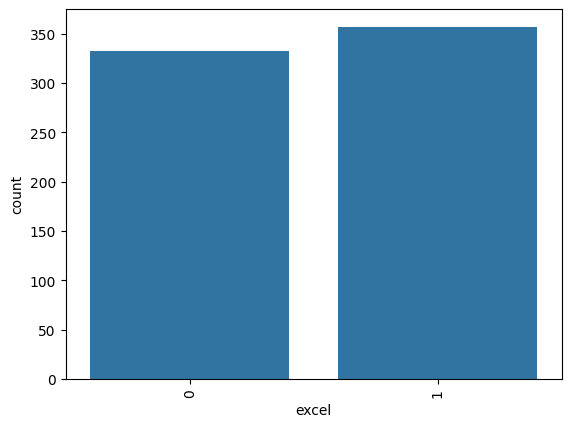

graph for job_simp: total = 7
7


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


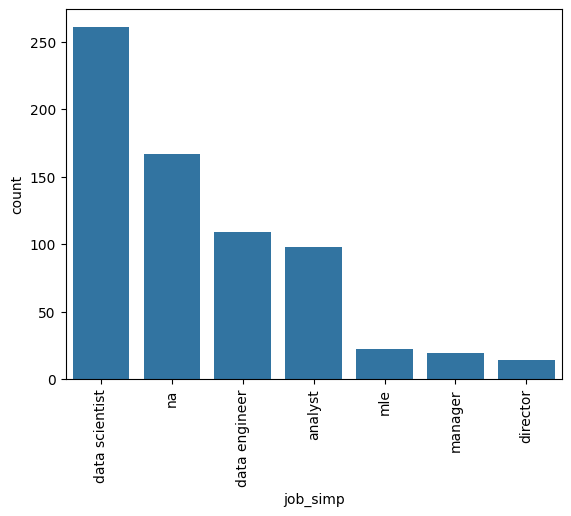

graph for seniority: total = 3
3


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_98010/1448843422.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


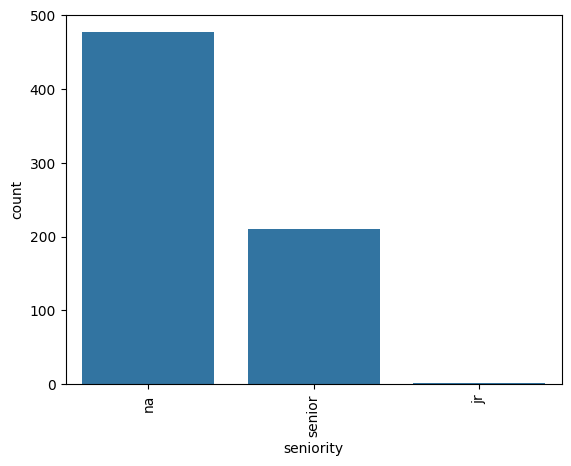

In [72]:
# print a bar plot
for i in df_cat.columns:
    cat_num = df_cat[i].value_counts()
    print("graph for %s: total = %d" % (i, len(cat_num)))
    # if too many values along x-axis, we will use only top-10(s)
    print(len(cat_num.index))
    n_top = 20
    chart = sns.barplot(x=cat_num.index[:n_top], y=cat_num[:n_top])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [73]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [74]:
pd.pivot_table(df, index = 'job_simp', values = 'avg_salary')

,avg_salary
job_simp,
analyst,66.306122
data engineer,106.188073
data scientist,116.509579
director,168.607143
manager,79.973684
mle,126.431818
na,83.520958


In [75]:
pd.pivot_table(df, index = ['job_simp','seniority'], values = 'avg_salary')

avg_salary
job_simp       seniority            
analyst        jr          56.500000
               na          61.514286
               senior      79.092593
data engineer  na          97.189189
               senior     125.214286
data scientist jr         106.500000
               na         105.985380
               senior     136.842697
director       na         168.607143
manager        na          79.973684
mle            na         119.133333
               senior     142.071429
na             na          71.855263
               senior     108.613208

In [76]:
pd.pivot_table(df, index = ['job_state','job_simp'], values = 'avg_salary').sort_values('job_state', ascending = False)

avg_salary
job_state job_simp                  
WI        na               54.000000
          data scientist  113.500000
          analyst          58.833333
WA        na               97.500000
          data scientist  100.437500
          analyst          54.500000
VA        na               79.300000
          mle              87.000000
          data scientist  108.416667
          data engineer    95.944444
          analyst          71.583333
UT        data scientist  140.500000
          analyst          47.000000
TX        na               41.285714
          data scientist   99.863636
          data engineer   113.062500
TN        data scientist   96.000000
          data engineer   100.950000
          analyst          13.500000
SC        na               60.500000
RI        analyst         100.000000
PA        na               76.062500
          mle             120.500000
          data scientist   89.333333
          analyst          62.750000
OR        data scientist   98.500000
          data engineer    73.000000
OH        na               91.166667
          data scientist  105.285714
          analyst          53.875000
NY        na               81.583333
          mle             125.000000
          data scientist  115.371795
          data engineer    86.375000
          analyst          65.607143
NM        data scientist   74.333333
NJ        data scientist  106.875000
          analyst          83.583333
          data engineer   112.000000
          director        161.500000
          manager         109.500000
          na               82.500000
NE        na               41.000000
NC        na               90.916667
          data scientist  117.000000
          data engineer   104.250000
MO        na               72.333333
          manager          40.500000
          data scientist  143.500000
          analyst          61.000000
MN        analyst          76.000000
          data engineer    95.000000
MI        data scientist  106.625000
          manager          87.500000
MD        na               88.750000
          data scientist  109.115385
          data engineer   109.000000
          analyst          80.666667
MA        na              105.702703
          manager          71.900000
          director        117.833333
          data scientist  114.431034
          data engineer   108.090909
          analyst          59.125000
LA        na               20.000000
          analyst          48.000000
KY        data scientist   84.000000
          na              103.500000
KS        mle              87.000000
IN        na               69.000000
          data scientist   84.500000
          data engineer   114.500000
IL        na               66.500000
          mle             133.000000
          director        221.750000
          data scientist  117.233333
          data engineer    96.125000
          analyst          66.500000
ID        analyst          56.250000
IA        data engineer    77.500000
          analyst          43.000000
GA        data scientist   81.333333
          na               80.000000
FL        data scientist   97.357143
          data engineer    91.833333
          analyst          47.500000
DE        na               27.500000
DC        data scientist  145.000000
          data engineer    85.000000
          analyst          63.500000
CT        na               62.500000
          data scientist   84.000000
CO        data scientist  108.666667
          analyst          29.500000
          data engineer    99.000000
          mle             100.500000
          na               31.500000
CA        na               98.934783
          mle             177.300000
          manager          80.611111
          data scientist  141.352459
          data engineer   129.540000
          analyst          87.470588
AZ        data scientist   69.500000
          data engineer    79.500000
          analyst          55.000000
          na              124.

In [77]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)

In [78]:
pd.pivot_table(df, index = ['job_state','job_simp'], values = 'avg_salary', aggfunc = 'count').sort_values('job_state', ascending = False)

avg_salary
job_state job_simp                  
WI        na                       4
          data scientist           3
          analyst                  3
WA        na                       1
          data scientist          16
          analyst                  3
VA        na                       5
          mle                      2
          data scientist          18
          data engineer            9
          analyst                  6
UT        data scientist           3
          analyst                  1
TX        na                       7
          data scientist          11
          data engineer            8
TN        data scientist           1
          data engineer           10
          analyst                  2
SC        na                       1
RI        analyst                  1
PA        na                       8
          mle                      7
          data scientist           3
          analyst                  8
OR        data scientist           3
          data engineer            1
OH        na                       3
          data scientist           7
          analyst                  4
NY        na                      12
          mle                      2
          data scientist          39
          data engineer            4
          analyst                 14
NM        data scientist           3
NJ        data scientist           4
          analyst                  6
          data engineer            2
          director                 2
          manager                  2
          na                       1
NE        na                       4
NC        na                      12
          data scientist           3
          data engineer            6
MO        na                       3
          manager                  1
          data scientist           2
          analyst                  2
MN        analyst                  1
          data engineer            1
MI        data scientist           4
          manager                  2
MD        na                      16
          data scientist          13
          data engineer            3
          analyst                  3
MA        na                      37
          manager                  5
          director                 6
          data scientist          29
          data engineer           11
          analyst                  4
LA        na                       1
          analyst                  1
KY        data scientist           2
          na                       4
KS        mle                      3
IN        na                       4
          data scientist           2
          data engineer            4
IL        na                       2
          mle                      2
          director                 6
          data scientist          15
          data engineer            8
          analyst                  3
ID        analyst                  2
IA        data engineer            1
          analyst                  2
GA        data scientist           3
          na                       3
FL        data scientist           7
          data engineer            3
          analyst                  6
DE        na                       6
DC        data scientist           3
          data engineer            4
          analyst                  2
CT        na                       3
          data scientist           2
CO        data scientist           3
          analyst                  1
          data engineer            3
          mle                      1
          na                       3
CA        na                      23
          mle                      5
          manager                  9
          data scientist          61
          data engineer           25
          analyst                 17
AZ        data scientist           1
          data engineer            5
          analyst                  1
          na                  

In [79]:
pd.pivot_table(df[df.job_simp == 'data scientist'], index = 'job_state', values = 'avg_salary').sort_values('avg_salary', ascending = False)

,avg_salary
job_state,
DC,145.000000
MO,143.500000
CA,141.352459
UT,140.500000
IL,117.233333
NC,117.000000
NY,115.371795
MA,114.431034
WI,113.500000


In [80]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [81]:
# rating, industry, sector, revenue, number of comp, hourly, employer provided, python, r, spark, aws, excel, desc_len, Type of onwership

In [82]:
df_pivots = df[['Rating', 'Industry', 'Sector', 'Revenue', 'num_comp', 'hourly', 'employer_provided', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'Type of ownership','avg_salary']]

In [83]:
for i in df_pivots.columns:
    print(f"Pivot by: {i}")
    try:
        pivot = pd.pivot_table(df_pivots, index=i, values='avg_salary')
        print(pivot.sort_values('avg_salary', ascending=False))
    except Exception as e:
        print(f"Skipped column '{i}' due to error: {e}")

Pivot by: Rating
        avg_salary
Rating            
5.0     121.166667
4.5     117.714286
4.1     116.368421
3.9     113.064516
2.6     109.083333
4.4     108.606061
4.2     106.925000
4.0     105.077778
3.7     104.879630
3.5     104.351064
4.7     103.983871
4.3     102.468750
3.2     102.142857
3.3     101.858974
2.2      97.750000
4.6      97.611111
3.8      96.811475
2.5      96.500000
3.4      93.104651
2.8      90.000000
1.9      87.500000
3.1      86.580000
3.0      85.588235
3.6      85.177778
2.7      83.250000
2.3      81.500000
4.8      80.277778
2.9      79.843750
2.1      72.500000
2.4      70.500000
Pivot by: Industry
                                          avg_salary
Industry                                            
Other Retail Stores                       163.500000
Motion Picture Production & Distribution  146.000000
Financial Analytics & Research            145.125000
Telecommunications Services               131.500000
Brokerage Services                    

In [84]:
pd.pivot_table(df_pivots, index = 'Revenue', columns = 'python_yn', values = 'avg_salary', aggfunc = 'count')

python_yn,0,1
Revenue,,
$1 to $2 billion (USD),16.0,44.0
$1 to $5 million (USD),1.0,7.0
$10 to $25 million (USD),16.0,16.0
$10+ billion (USD),66.0,58.0
$100 to $500 million (USD),43.0,42.0
$2 to $5 billion (USD),17.0,21.0
$25 to $50 million (USD),21.0,16.0
$5 to $10 billion (USD),9.0,10.0
$5 to $10 million (USD),5.0,NaN


In [85]:
import ssl
import certifi

print(ssl.get_default_verify_paths())
print(certifi.where())

DefaultVerifyPaths(cafile=None, capath=None, openssl_cafile_env='SSL_CERT_FILE', openssl_cafile='/Library/Frameworks/Python.framework/Versions/3.12/etc/openssl/cert.pem', openssl_capath_env='SSL_CERT_DIR', openssl_capath='/Library/Frameworks/Python.framework/Versions/3.12/etc/openssl/certs')
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_4/.venv/lib/python3.12/site-packages/certifi/cacert.pem


In [86]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import ssl

# Bypass SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

# --- Force download before anything else ---
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')  # Ensure punkt_tab is downloaded if required


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zepyoorkhechadoorian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zepyoorkhechadoorian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zepyoorkhechadoorian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

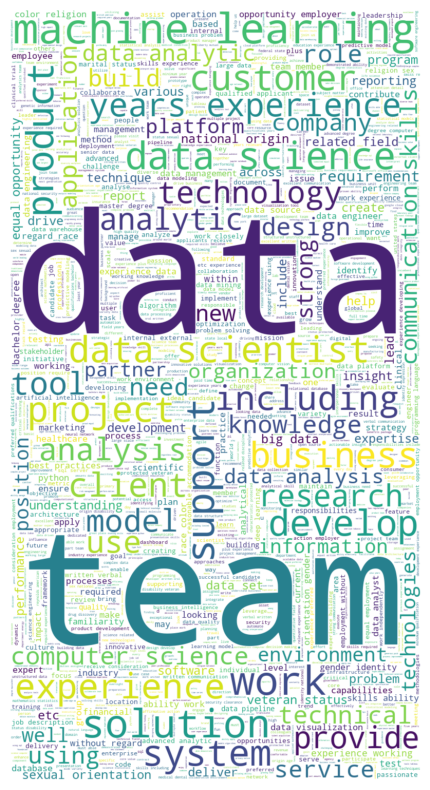

In [87]:
# --- Proceed after downloading ---
words = " ".join(df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)  # punkt is needed here
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered

words_filtered = punctuation_stop(words)
text = " ".join(words_filtered)

wc = WordCloud(
    background_color="white",
    random_state=1,
    stopwords=STOPWORDS,
    max_words=2000,
    width=800,
    height=1500
)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


In [88]:
df.to_csv('eda_data.csv')